In [271]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import digamma, gammaln

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

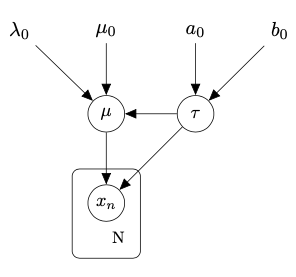

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [272]:
def generate_data(mu, tau, N):
  x = np.linspace(-10, 10, N)
  # Insert your code here
  sigma = 1 / np.sqrt(tau)   # precision τ = 1/σ²
  np.random.seed(10)
  D = np.random.normal(mu, sigma, N)

  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



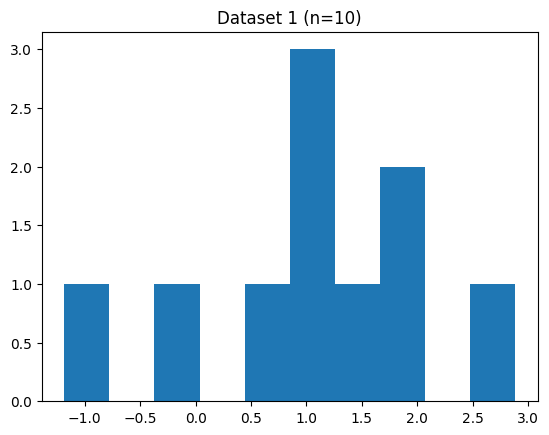

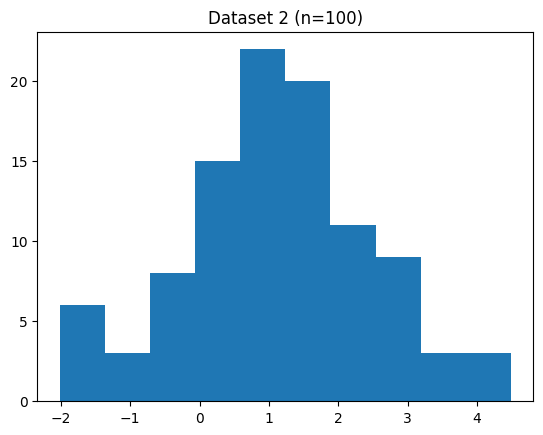

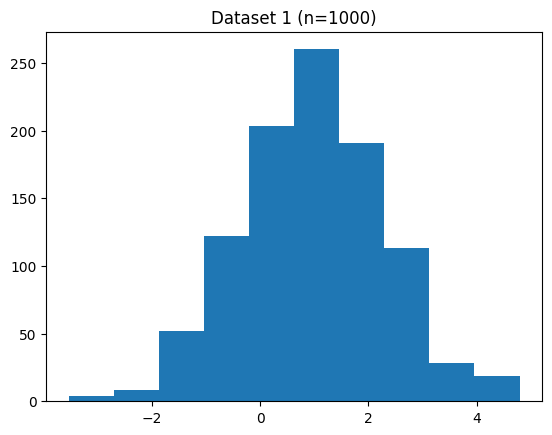

In [273]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
#
#
#
plt.figure()
plt.hist(dataset_1)
plt.title("Dataset 1 (n=10)")

plt.figure()
plt.hist(dataset_2)
plt.title("Dataset 2 (n=100)")

plt.figure()
plt.hist(dataset_3)
plt.title("Dataset 1 (n=1000)")

plt.show()


### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [274]:
# from the theory we know that:
# mu_ml = 1/n * sum(x_i)
# tau_ml = n / sum((x_i - mu_ml)(x_i - mu_ml)^T)
def ML_est(data):
  mu_ml= np.mean(data)
  variance_ml = np.var(data, ddof=0)
  tau_ml= 1/variance_ml
  return mu_ml, tau_ml

## Test the ML estimator on the three datasets
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))

(np.float64(1.0845817205152941), np.float64(0.884224414821371))
(np.float64(1.1123121218037397), np.float64(0.5346648053646902))
(np.float64(0.9794138084900784), np.float64(0.5683337478172712))


### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [275]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # s = star -> new value for posterior
  N = len(D)
  alpha_s = N/2 + a_0
  lambda_s = N + lambda_0
  mu_s = (np.sum(D) + mu_0*lambda_0)/lambda_s
  beta_s =  b_0 + 0.5*(np.sum(D**2)+lambda_0*(mu_0**2) - lambda_s*(mu_s**2))

  exact_post_dist_parameters = (alpha_s, beta_s, mu_s, lambda_s)
  return exact_post_dist_parameters

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [276]:
# prior parameters
mu_0 = 1.0
lambda_0 = 0.1 
a_0 = 1.0
b_0 = 2.0      

Continue with a helper function that computes ELBO:


In [277]:
from scipy.stats import gamma, norm
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  N = len(D)
  
  # Pre-compute expectations
  E_tau = a_N / b_N
  E_log_tau= digamma(a_N) - np.log(b_N)
  E_mu = mu_N
  E_mu_squared = (1.0 / (lambda_N * E_tau)) + mu_N**2
  
  sum_x = np.sum(D)
  sum_x_squared = np.sum(D**2)
  
  #ELBO = - KL[q|| p]
  
  # E_q[P(mu | tau)]
  Eq_log_p_mu_given_tau =  0.5 * np.log(lambda_0 / (2*np.pi)) \
                          + 0.5 * E_log_tau \
                          - (lambda_0 * E_tau / 2.0) * (E_mu_squared - 2*E_mu*mu_0 + mu_0**2)
  
  # E_q[P(tau)]
  Eq_log_p_tau=  a_0 * np.log(b_0) \
                    - gammaln(a_0) \
                    + (a_0 - 1) * E_log_tau \
                    - b_0 * E_tau
  
  # E_q[P(D|mu, tau)]
  Eq_log_p_D_given_mu_tau = (N / 2.0) * E_log_tau \
                            - (N / 2.0) * np.log(2 * np.pi) \
                            - (E_tau / 2.0) * (sum_x_squared - 2*E_mu*sum_x + N*E_mu_squared)



  # -E_q[q(mu)]
  entropy_mu = 0.5 * (1 + np.log(2*np.pi)) \
               - 0.5 * np.log(lambda_N) \
               - 0.5 * E_log_tau
               
  # -E_q[q(tau)]
  entropy_tau = -a_N * np.log(b_N) \
                  + gammaln(a_N) \
                  - (a_N - 1) * E_log_tau \
                  + b_N * E_tau
    
  # ELBO
  elbo = Eq_log_p_mu_given_tau \
        + Eq_log_p_tau \
        + Eq_log_p_D_given_mu_tau \
        + entropy_mu \
        + entropy_tau


  return elbo


Now, implement the CAVI algorithm:

In [278]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = a_0/b_0 # given
  E_tau = initial_guess_exp_tau
  
  elbos = []
  elbos.append(0)
  eps = np.finfo(float).eps # Machine EPS
  i = 0
  diff = float("inf")
  
  N = len(D)
  sum_x = np.sum(D)
  sum_x2 = np.sum(D**2)
  
  while diff >= eps:
    
    lambda_N = (lambda_0 + N)*E_tau
    mu_N = (lambda_0 * mu_0 + sum_x) / (lambda_0 + N)
    
    E_mu = mu_N
    E_mu2 = 1/lambda_N**2 + E_mu**2
 
    a_N = a_0 + (N + 1) / 2.0
    b_N = (
      b_0 
      + 0.5*sum_x2
      + 0.5*E_mu2*(lambda_0 + N)
      - E_mu*(lambda_0*mu_0 + sum_x)
      + 0.5*lambda_0*(mu_0**2)
    )
    
    E_tau = a_N/b_N
    
    i += 1
    elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
    elbos.append(elbo)
    diff = abs(elbos[i] - elbos[i-1])
  
  elbos.pop(0)
  return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


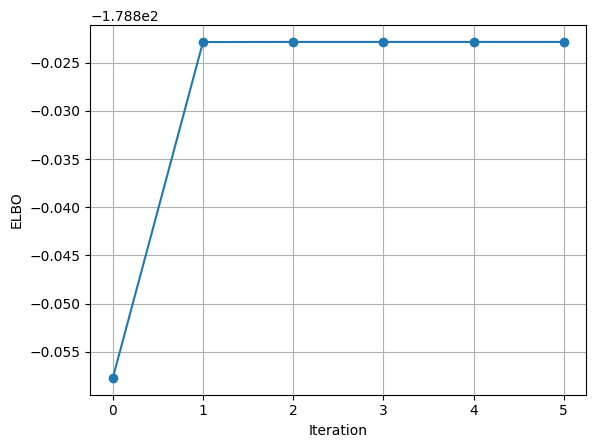

In [279]:
# Insert your main code here

data = dataset_2 # Example with dataset_2
mu_ml, tau_ml = ML_est(data=data)

a_N, b_N, mu_n, lambda_N, elbos = CAVI(data, a_0, b_0, mu_0, lambda_0)

it = len(elbos)
X = np.arange(it)

plt.plot(X, elbos, marker='o')
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.show()

compute_exact_posterior = compute_exact_posterior(data, a_0, b_0, mu_0, lambda_0)

# Missing
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot


